In [1]:
%%capture
from phase3 import nda, func
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import caveclient
client = caveclient.CAVEclient('minnie65_public_v343')
cr_df = client.materialize.query_table('functional_coreg')

In [2]:
my_good_scans=pd.DataFrame(nda.Scan & nda.ScanInclude)
my_good_scans

,session,scan_idx,nframes,nfields,fps
0,4,7,40000,8,6.30090
1,5,6,40000,8,6.30090
2,5,7,40000,8,6.30090
3,6,2,40000,8,6.30090
4,6,4,40000,8,6.30090
5,6,6,40000,8,6.30090
6,6,7,40000,8,6.30090
7,7,3,40000,8,6.30090
8,7,4,40000,8,6.30090
9,7,5,40000,8,6.30090


In [6]:
coreg_df = client.materialize.query_table('functional_coreg')

In [7]:
coreg_good_scans = pd.merge(my_good_scans, coreg_df, on=['session','scan_idx'], how='inner')

In [5]:
coreg_good_scans

,session,scan_idx,nframes,nfields,fps,id,valid,pt_supervoxel_id,pt_root_id,unit_id,pt_position
0,4,7,40000,8,6.30090,1,t,102531727972419182,864691136136642173,665,"[274864, 94064, 22046]"
1,4,7,40000,8,6.30090,2,t,94792540099826672,864691136208993724,740,"[218320, 104320, 19016]"
2,4,7,40000,8,6.30090,4,t,93946810036875732,864691135683934135,782,"[212128, 94544, 23423]"
3,4,7,40000,8,6.30090,5,t,84730565597057981,864691135334528233,855,"[145158, 110036, 19355]"
4,4,7,40000,8,6.30090,6,t,110905058841147285,864691136309730650,921,"[335744, 90128, 22805]"
...,...,...,...,...,...,...,...,...,...,...,...
8939,9,6,57000,4,9.62246,4408,t,109783143724206405,864691135809463500,4984,"[327696, 119968, 15423]"
8940,9,6,57000,4,9.62246,4410,t,103309632650391933,864691136020330744,5197,"[280496, 122672, 23563]"
8941,9,6,57000,4,9.62246,4409,t,107039381914778927,864691136118618136,5071,"[307334, 124302, 21068]"
8942,9,6,57000,4,9.62246,5428,t,108939337537952907,864691136535165346,4144,"[321408, 124304, 17607]"


In [6]:
#create a dictionary of indivicual presentations of a direction (#condition_hash) organized by the following keys and make that a pandas dataframe

keys = ["condition_hash", "directions", "onsets"]
monet_df = pd.DataFrame(dict(zip(keys, nda.Monet2.fetch(*keys))))

In [7]:
# create a trial df with information from the monet stim for every trial in every scan 
trial_df = pd.DataFrame(nda.Trial & nda.Monet2 & nda.ScanInclude)

In [8]:
#merge the two dataframes and expand the contents of directions and onsets to populate their own rows
monet_pres_df = pd.merge(trial_df, monet_df, on='condition_hash').explode(["directions", "onsets"]).explode(["directions", "onsets"])

In [9]:
#calculate the onsest_frame in seconds, add to new column in the dataframe
monet_pres_df["onset_frame_time"] = monet_pres_df["start_frame_time"] + monet_pres_df["onsets"] 

In [10]:
#calculate the offset frame, add to new column in the data frame
monet_pres_df["offset_frame_time"] = monet_pres_df["onset_frame_time"] + (15/16) 

In [11]:
monet_pres_df.drop(columns=['type','start_idx','end_idx','start_frame_time','end_frame_time','frame_times'],inplace=True)

In [12]:
monet_pres_df['onset_frame'] = (monet_pres_df['onset_frame_time']*6.3).astype(int)

monet_pres_df['offset_frame'] = (monet_pres_df['offset_frame_time']*6.3).astype(int)


In [13]:
coreg_good_scans_dsi_osis = {}

for scan_key_tuple, monet_pres_scan_df in monet_pres_df.groupby(["session", "scan_idx"]):
    print(scan_key_tuple)
    
    scan_key = {'session':scan_key_tuple[0], 'scan_idx':scan_key_tuple[1]}
    unit_ids, traces = (nda.Activity & scan_key).fetch("unit_id", "trace")
    traces = np.array(list(map(list, traces)))
    activity_sums =[]
    for ind, row in monet_pres_scan_df.iterrows():
        activity_sum = np.sum(traces[:, row['onset_frame']:row['offset_frame']], axis=1)
        activity_sums.append(activity_sum)
    activity_sums = np.array(activity_sums)
    unit_acts = dict(zip(unit_ids, activity_sums.T))
    unit_act_df = pd.DataFrame(unit_acts)
    scan_activity_df=pd.concat([monet_pres_scan_df.reset_index(drop=True), unit_act_df], axis=1)
    
    dirs_mean = scan_activity_df.groupby('directions').mean().drop(columns = ['session','scan_idx','trial_idx','onset_frame','offset_frame'])
    ors_mean = dirs_mean.copy()
    ors_mean.index = ors_mean.index % 180
    ors_mean = ors_mean.reset_index().rename(columns={"directions": "orientations"}).groupby("orientations").mean()
    
    pref_dir_df = pd.concat([pd.DataFrame(dirs_mean.idxmax(axis=0), columns=['pref_dir']).T, dirs_mean], axis=0)
    pref_dir_df.loc['null_dir'] = (pref_dir_df.loc['pref_dir']+180)%360
    
    pref_or_df = pd.concat([pd.DataFrame(ors_mean.idxmax(axis=0), columns=['pref_or']).T, ors_mean], axis=0)
    pref_or_df.loc['null_or'] = (pref_or_df.loc['pref_or']+90)%180
    
########## calculate dsis ########

    dsis = []
    pref_activities = []
    for ind, row in pref_dir_df.loc[["pref_dir", "null_dir"]].T.iterrows():
        pref_activity = pref_dir_df.loc[row['pref_dir'], ind]
        null_activity = pref_dir_df.loc[row['null_dir'],ind]
        dsis.append((pref_activity - null_activity)/(pref_activity + null_activity))
        pref_activities.append(pref_activity)

    pref_dir_df.loc['DSI'] = dsis  
    pref_dir_df.loc['Act_Pref_Dir'] = pref_activities  
    
    osis = []
    pref_activities = []
    for ind, row in pref_or_df.loc[["pref_or", "null_or"]].T.iterrows():
        pref_activity = pref_or_df.loc[row['pref_or'], ind]
        null_activity = pref_or_df.loc[row['null_or'],ind]
        osis.append((pref_activity - null_activity)/(pref_activity + null_activity))
        pref_activities.append(pref_activity)

    pref_dir_df.loc['OSI'] = osis  
    pref_dir_df.loc['Act_Pref_Or'] = pref_activities  
    pref_dir_df.loc['pref_or'] = pref_or_df.loc['pref_or']
    pref_dir_df.loc['null_or'] = pref_or_df.loc['null_or']
    
    # pref_dir_dsis[scan_key_tuple] = pref_dir_df  
    
######filter for co-reg cells #######
    co_reg = coreg_good_scans.query(f'session == {scan_key_tuple[0]} and scan_idx == {scan_key_tuple[1]}')
    
    pref_dir_df_re_indx = pref_dir_df.T.reset_index()
    pref_dir_df_re_indx.rename(columns = {'index' : 'unit_id'}, inplace=True)
    coreg_good_scans_dsi_osi = pd.merge(pref_dir_df_re_indx, co_reg, on=['unit_id'], how='inner')
    coreg_good_scans_dsi_osis[scan_key_tuple] = coreg_good_scans_dsi_osi
   

(4, 7)
(5, 6)
(5, 7)
(6, 2)
(6, 4)
(6, 6)
(6, 7)
(7, 3)
(7, 4)
(7, 5)
(8, 5)
(9, 3)
(9, 4)
(9, 6)


In [14]:
coreg_all_good_scans_dsi_osi=pd.concat(coreg_good_scans_dsi_osis.values())

In [15]:
coreg_all_good_scans_dsi_osi.columns = [str(col) for col in coreg_all_good_scans_dsi_osi.columns]

In [16]:
coreg_all_good_scans_dsi_osi.reset_index(drop = True).to_feather(r'coreg_all_good_scans_dsi_osi.feather')
coreg_all_good_scans_dsi_osi.reset_index(drop = True).to_csv(r'coreg_all_good_scans_dsi_osi.csv')

In [17]:
coreg_all_good_scans_dsi_osi.columns

Index(['unit_id', 'pref_dir', '0.0', '22.5', '45.0', '67.5', '90.0', '112.5',
       '135.0', '157.5', '180.0', '202.5', '225.0', '247.5', '270.0', '292.5',
       '315.0', '337.5', 'null_dir', 'DSI', 'Act_Pref_Dir', 'OSI',
       'Act_Pref_Or', 'pref_or', 'null_or', 'session', 'scan_idx', 'nframes',
       'nfields', 'fps', 'id', 'valid', 'pt_supervoxel_id', 'pt_root_id',
       'pt_position'],
      dtype='object')

In [3]:
coreg_all_good_scans_dsi_osi = pd.read_feather('coreg_all_good_scans_dsi_osi.feather')

In [4]:
coreg_all_good_scans_dsi_osi.columns

Index(['unit_id', 'pref_dir', '0.0', '22.5', '45.0', '67.5', '90.0', '112.5',
       '135.0', '157.5', '180.0', '202.5', '225.0', '247.5', '270.0', '292.5',
       '315.0', '337.5', 'null_dir', 'DSI', 'Act_Pref_Dir', 'OSI',
       'Act_Pref_Or', 'pref_or', 'null_or', 'session', 'scan_idx', 'nframes',
       'nfields', 'fps', 'id', 'valid', 'pt_supervoxel_id', 'pt_root_id',
       'pt_position'],
      dtype='object')

In [5]:
coreg_all_good_scans_dsi_osi["Activity Preferred Direction_log"] = np.log10(coreg_all_good_scans_dsi_osi['Act_Pref_Dir'])

In [6]:
coreg_all_good_scans_dsi_osi["Activity Preferred Orientation_log"] = np.log10(coreg_all_good_scans_dsi_osi['Act_Pref_Or'])

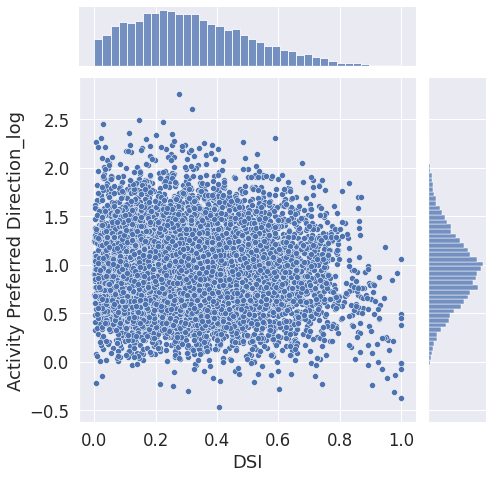

In [7]:
#scatterplot of mean activity of pref.dir vs. DSI
sns.set(font_scale = 1.5)
g = sns.jointplot(data=coreg_all_good_scans_dsi_osi[~coreg_all_good_scans_dsi_osi.index.duplicated()], x="DSI", y="Activity Preferred Direction_log", height=7) 


In [8]:
coreg_all_good_scans_dsi_osi[~coreg_all_good_scans_dsi_osi.index.duplicated()]

,unit_id,pref_dir,0.0,22.5,45.0,67.5,90.0,112.5,135.0,157.5,...,nframes,nfields,fps,id,valid,pt_supervoxel_id,pt_root_id,pt_position,Activity Preferred Direction_log,Activity Preferred Orientation_log
0,648,135.0,3.869289,2.569276,5.308732,1.298307,2.465255,2.823838,6.249678,3.144921,...,40000,8,6.30090,7011,t,105487283075448380,864691135348268503,"[296167, 94711, 15794]",0.795858,0.620968
1,662,22.5,59.754860,67.039787,35.522396,19.603022,44.217720,26.546534,29.701845,65.622772,...,40000,8,6.30090,7631,t,101758289725398433,864691136105667033,"[269248, 98832, 18382]",1.826333,1.787314
2,664,157.5,15.440701,5.753352,3.858135,4.874376,1.157665,8.875190,12.583257,23.973148,...,40000,8,6.30090,9316,t,102391814782283804,864691136124057126,"[273716, 100363, 19517]",1.379725,1.282941
3,665,247.5,1.312480,1.510452,1.538439,1.803000,1.202386,1.151717,1.864479,1.073156,...,40000,8,6.30090,1,t,102531727972419182,864691136136642173,"[274864, 94064, 22046]",0.420395,0.345928
4,671,157.5,1.792641,0.564024,0.602408,4.894426,1.979802,2.038813,5.237404,9.921950,...,40000,8,6.30090,6241,t,100491446037107979,864691135941155444,"[259731, 97037, 16967]",0.996597,0.965798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8939,4929,247.5,12.167885,7.213950,11.504935,6.147285,3.726009,3.264073,4.492246,3.898719,...,57000,4,9.62246,2363,t,84945451266315496,864691136711097710,"[146544, 138320, 18077]",1.292433,1.140570
8940,4964,0.0,4.342972,3.719285,3.437874,2.371579,2.978190,3.465529,3.569629,3.793038,...,57000,4,9.62246,4407,t,108516643835343008,864691136541617826,"[318352, 120736, 16177]",0.637787,0.578133
8941,4984,22.5,2.270859,3.066604,2.930989,2.868988,1.773696,2.779382,2.918294,2.681094,...,57000,4,9.62246,4408,t,109783143724206405,864691135809463500,"[327696, 119968, 15423]",0.486658,0.483212
8942,5071,225.0,3.158532,8.183872,10.438069,9.720421,3.625013,9.049018,14.051265,1.444680,...,57000,4,9.62246,4409,t,107039381914778927,864691136118618136,"[307334, 124302, 21068]",1.243370,1.145375


Text(0, 0.5, 'Count')

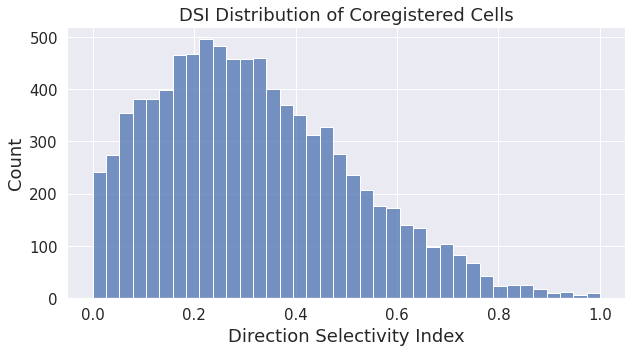

In [9]:
plot_df_all_coreg = coreg_all_good_scans_dsi_osi.loc[:,'DSI'].values
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=plot_df_all_coreg)
ax.set_title('DSI Distribution of Coregistered Cells', fontsize=18)
ax.set_xlabel('Direction Selectivity Index', fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.set_ylabel('Count', fontsize=18)

In [10]:

high_dsi_m = np.array(coreg_all_good_scans_dsi_osi['DSI']>=0.65)
low_dsi_m = np.array(coreg_all_good_scans_dsi_osi['DSI']<=0.2)
mean_act_m = np.array(coreg_all_good_scans_dsi_osi['Act_Pref_Dir']>=20)



In [11]:
np.sum(high_dsi_m & mean_act_m)

86

In [12]:
high_dsi_high_activity = coreg_all_good_scans_dsi_osi[high_dsi_m & mean_act_m]

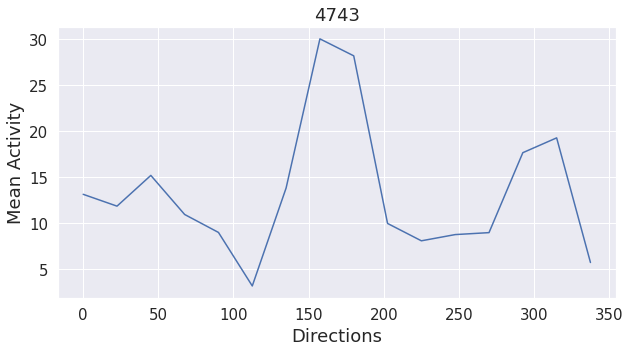

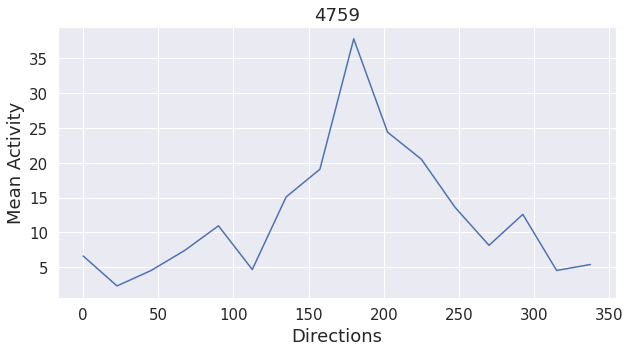

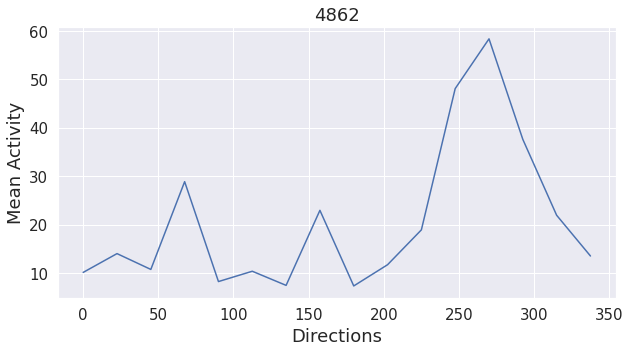

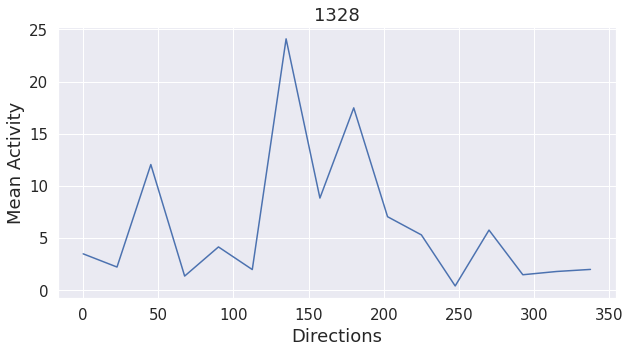

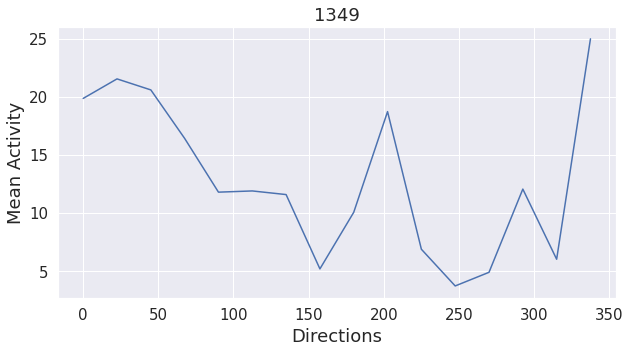

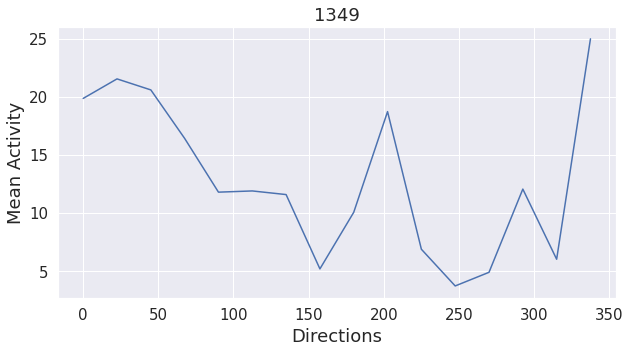

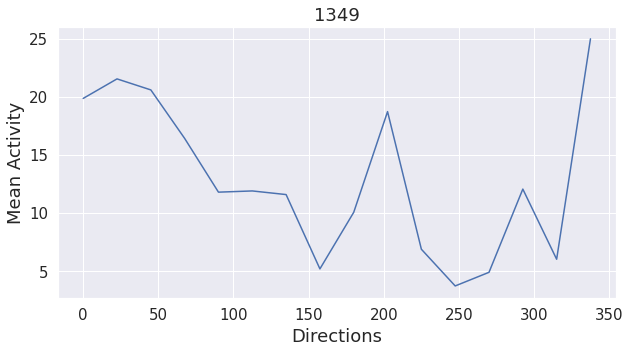

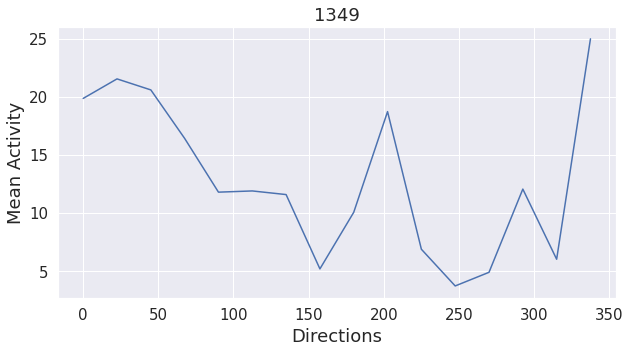

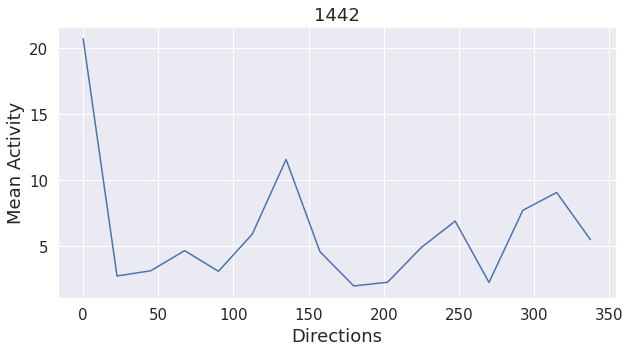

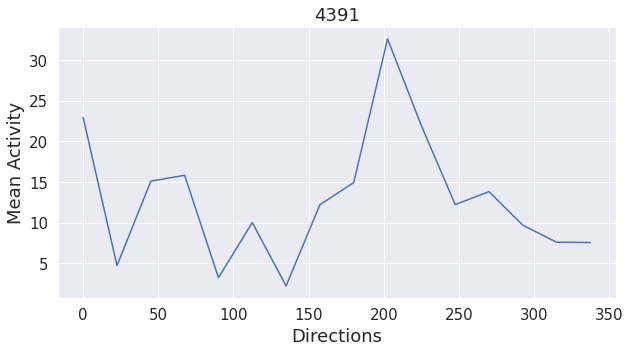

In [43]:
for ind, row in high_dsi_high_activity[30:40].iterrows():
    angles=np.arange(0,360,22.5)
    angle_strs= [str(k) for k in angles]
    tuning_curve = row[angle_strs]
    this_unit_id = row['unit_id']
    
    
    f, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(x=angles, y = tuning_curve, ax=ax)
    ax.set_title(str(this_unit_id),fontsize=18)
   
    ax.set_xlabel('Directions', fontsize=18)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    ax.set_ylabel('Mean Activity', fontsize=18)

In [15]:
np.sum(low_dsi_m & mean_act_m)

478

In [16]:
low_dsi_high_activity = coreg_all_good_scans_dsi_osi[low_dsi_m & mean_act_m]

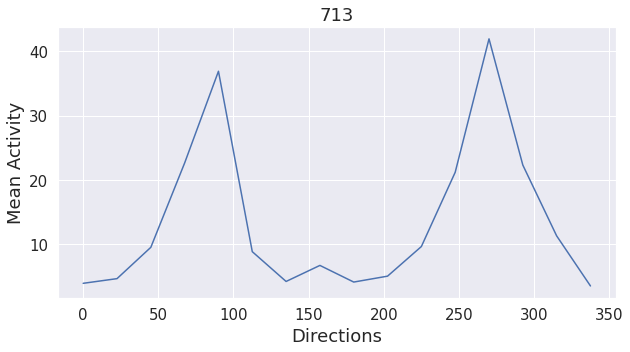

In [17]:
for ind, row in low_dsi_high_activity[:1].iterrows():
    angles=np.arange(0,360,22.5)
    angle_strs= [str(k) for k in angles]
    tuning_curve = row[angle_strs]
    this_unit_id = row['unit_id']
    
    f, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(x=angles, y = tuning_curve, ax=ax)
    ax.set_title(str(this_unit_id))
    ax.set_ylabel('Mean Activity')
    
    ax.set_xlabel('Directions', fontsize=18)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    ax.set_ylabel('Mean Activity', fontsize=18)

Text(0, 0.5, 'Count')

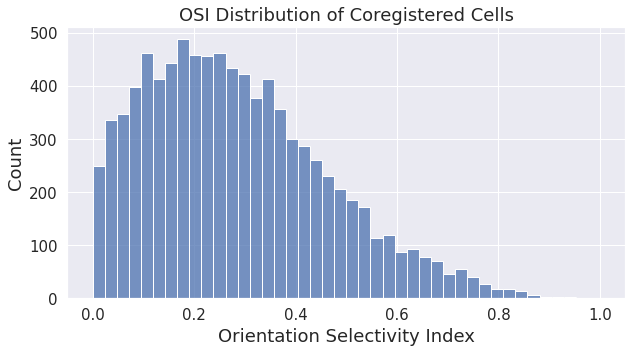

In [18]:

plot_df_all_coreg = coreg_all_good_scans_dsi_osi.loc[:,'OSI'].values
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=plot_df_all_coreg)
ax.set_title('OSI Distribution of Coregistered Cells',fontsize=18)
ax.set_xlabel('Orientation Selectivity Index',fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.set_ylabel('Count', fontsize=18)

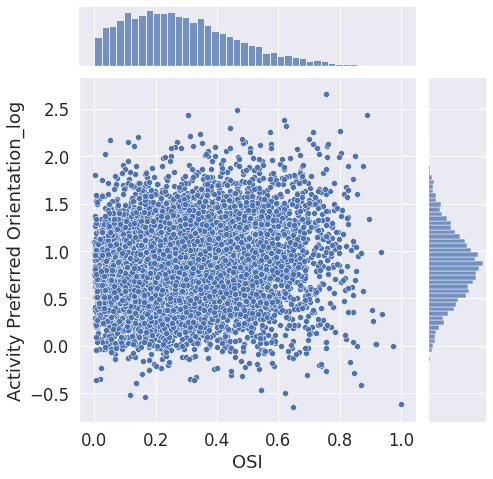

In [19]:
sns.set(font_scale = 1.5)
g = sns.jointplot(data=coreg_all_good_scans_dsi_osi[~coreg_all_good_scans_dsi_osi.index.duplicated()], x="OSI", y="Activity Preferred Orientation_log", height=7) 

In [20]:
high_osi_m = np.array(coreg_all_good_scans_dsi_osi['OSI']>=0.7)
low_osi_m = np.array(coreg_all_good_scans_dsi_osi['OSI']<=0.2)
mean_act_m = np.array(coreg_all_good_scans_dsi_osi['Act_Pref_Or']>=20)



In [21]:
np.sum(mean_act_m & high_osi_m )

64

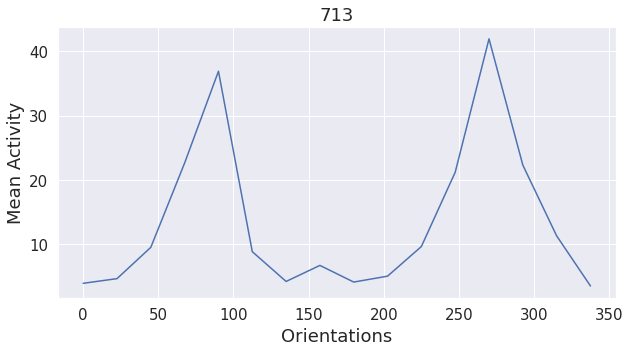

In [22]:
high_osi_high_activity = coreg_all_good_scans_dsi_osi[high_osi_m & mean_act_m]


for ind, row in high_osi_high_activity[:1].iterrows():
    angles=np.arange(0,360,22.5)
    angle_strs= [str(k) for k in angles]
    tuning_curve = row[angle_strs]
    this_unit_id = row['unit_id']
    
    f, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(x=angles, y = tuning_curve, ax=ax)
    ax.set_title(str(this_unit_id))
    
    ax.set_xlabel('Orientations', fontsize=18)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    ax.set_ylabel('Mean Activity', fontsize=18)

In [23]:
low_osi_high_activity = coreg_all_good_scans_dsi_osi[low_osi_m & mean_act_m]

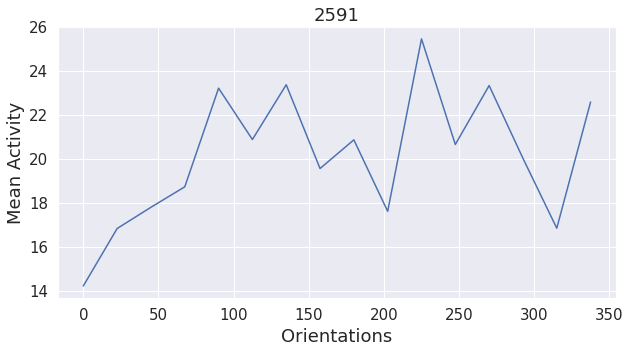

In [24]:
for ind, row in low_osi_high_activity[:1].iterrows():
    angles=np.arange(0,360,22.5)
    angle_strs= [str(k) for k in angles]
    tuning_curve = row[angle_strs]
    this_unit_id = row['unit_id']
    
    f, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(x=angles, y = tuning_curve, ax=ax)
    ax.set_title(str(this_unit_id))
    
    ax.set_xlabel('Orientations', fontsize=18)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    ax.set_ylabel('Mean Activity', fontsize=18)

In [25]:
high_DSI_m = np.array(coreg_all_good_scans_dsi_osi['DSI']>=0.7)
low_DSI_m = np.array(coreg_all_good_scans_dsi_osi['DSI']<=0.2)
low_mean_act_m = np.array(coreg_all_good_scans_dsi_osi['Act_Pref_Dir']<=10)

In [26]:
high_DSI_low_activity = coreg_all_good_scans_dsi_osi[high_DSI_m & low_mean_act_m]

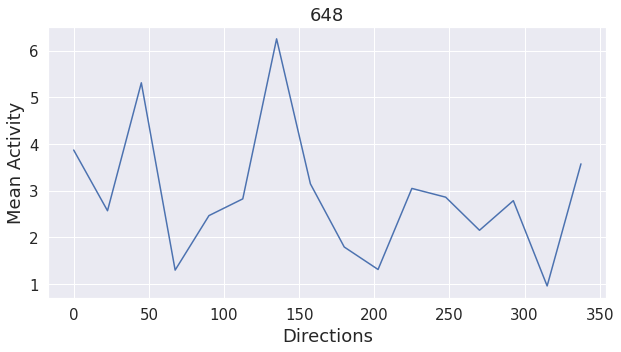

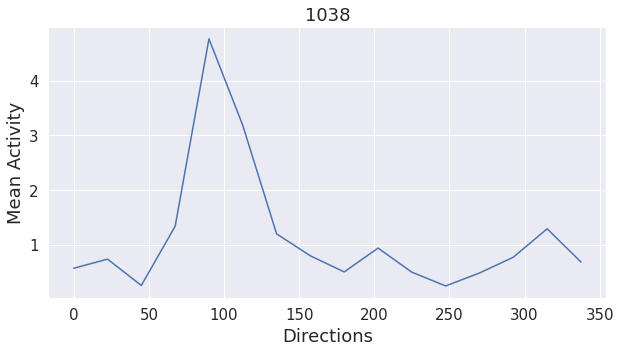

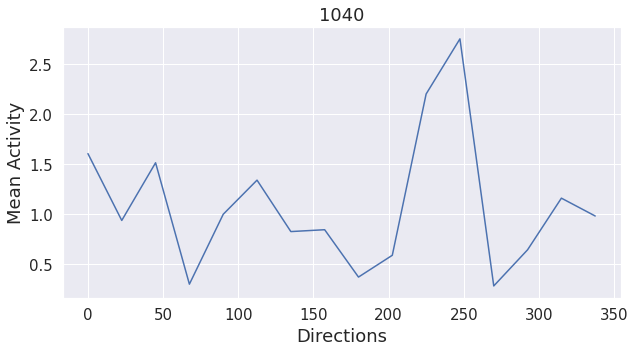

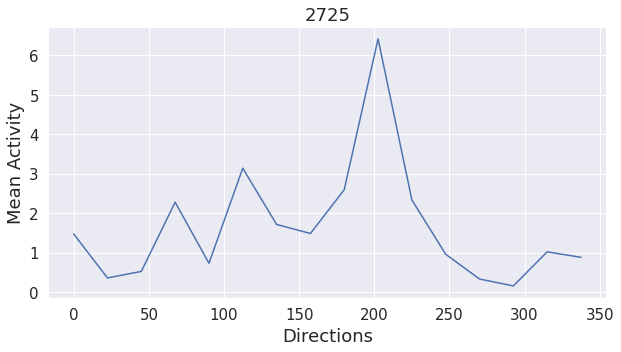

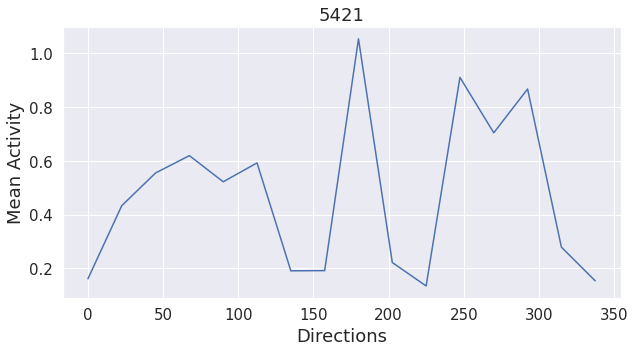

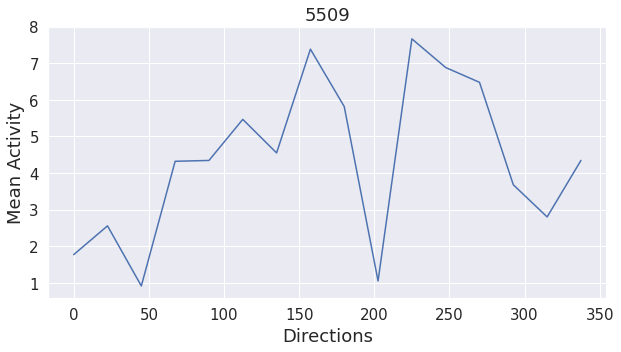

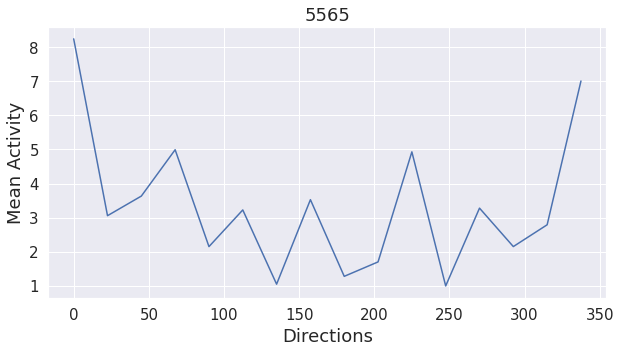

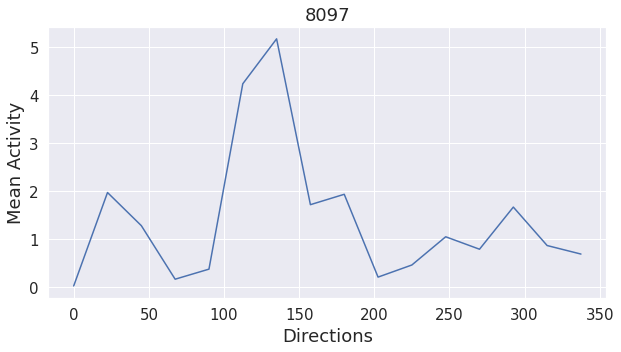

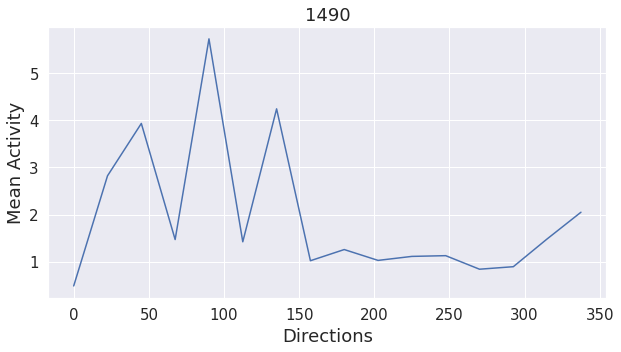

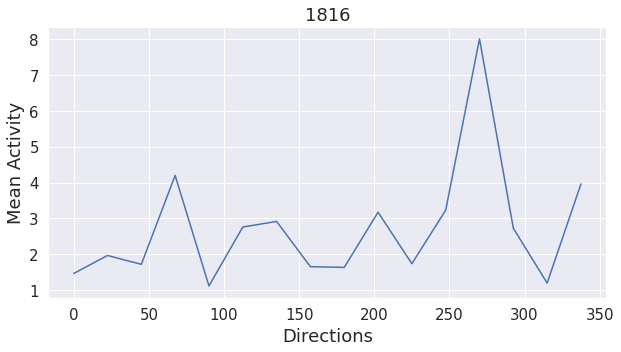

In [27]:
for ind, row in high_DSI_low_activity[:10].iterrows():
    angles=np.arange(0,360,22.5)
    angle_strs= [str(k) for k in angles]
    tuning_curve = row[angle_strs]
    this_unit_id = row['unit_id']
    
    f, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(x=angles, y = tuning_curve, ax=ax)
    ax.set_title(str(this_unit_id))
    
    ax.set_xlabel('Directions', fontsize=18)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    ax.set_ylabel('Mean Activity', fontsize=18)

In [28]:
high_osi_m = np.array(coreg_all_good_scans_dsi_osi['OSI']>=0.7)
low_osi_m = np.array(coreg_all_good_scans_dsi_osi['OSI']<=0.2)
low_mean_act_m = np.array(coreg_all_good_scans_dsi_osi['Act_Pref_Or']<=10)

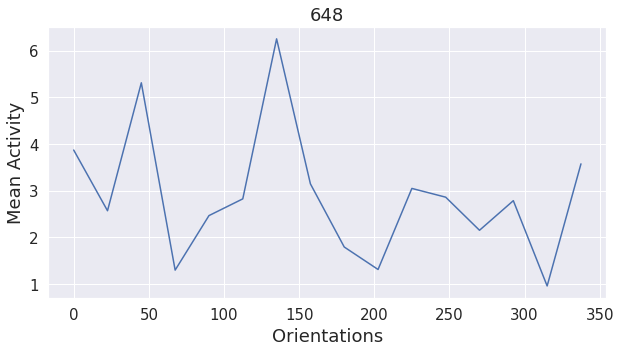

In [29]:
high_osi_low_activity = coreg_all_good_scans_dsi_osi[low_osi_m & low_mean_act_m] 

for ind, row in high_osi_low_activity[:1].iterrows():
    angles=np.arange(0,360,22.5)
    angle_strs= [str(k) for k in angles]
    tuning_curve = row[angle_strs]
    this_unit_id = row['unit_id']
    
    f, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(x=angles, y = tuning_curve, ax=ax)
    ax.set_title(str(this_unit_id))
    
    ax.set_xlabel('Orientations', fontsize=18)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    ax.set_ylabel('Mean Activity', fontsize=18)

In [30]:
coreg_all_good_scans_dsi_osi.columns

Index(['unit_id', 'pref_dir', '0.0', '22.5', '45.0', '67.5', '90.0', '112.5',
       '135.0', '157.5', '180.0', '202.5', '225.0', '247.5', '270.0', '292.5',
       '315.0', '337.5', 'null_dir', 'DSI', 'Act_Pref_Dir', 'OSI',
       'Act_Pref_Or', 'pref_or', 'null_or', 'session', 'scan_idx', 'nframes',
       'nfields', 'fps', 'id', 'valid', 'pt_supervoxel_id', 'pt_root_id',
       'pt_position', 'Activity Preferred Direction_log',
       'Activity Preferred Orientation_log'],
      dtype='object')

In [31]:
high_dsi_m = np.array(coreg_all_good_scans_dsi_osi['DSI']>=0.65)
low_dsi_m = np.array(coreg_all_good_scans_dsi_osi['DSI']<=0.2)
mean_act_m = np.array(coreg_all_good_scans_dsi_osi['Act_Pref_Dir']>=20)


In [32]:
np.sum(high_dsi_m & mean_act_m)

86

In [33]:
upper_right_quad_DSI = coreg_all_good_scans_dsi_osi[high_dsi_m & mean_act_m]

In [35]:
upper_right_quad_DSI.columns

Index(['unit_id', 'pref_dir', '0.0', '22.5', '45.0', '67.5', '90.0', '112.5',
       '135.0', '157.5', '180.0', '202.5', '225.0', '247.5', '270.0', '292.5',
       '315.0', '337.5', 'null_dir', 'DSI', 'Act_Pref_Dir', 'OSI',
       'Act_Pref_Or', 'pref_or', 'null_or', 'session', 'scan_idx', 'nframes',
       'nfields', 'fps', 'id', 'valid', 'pt_supervoxel_id', 'pt_root_id',
       'pt_position', 'Activity Preferred Direction_log',
       'Activity Preferred Orientation_log'],
      dtype='object')

Text(0, 0.5, 'Count')

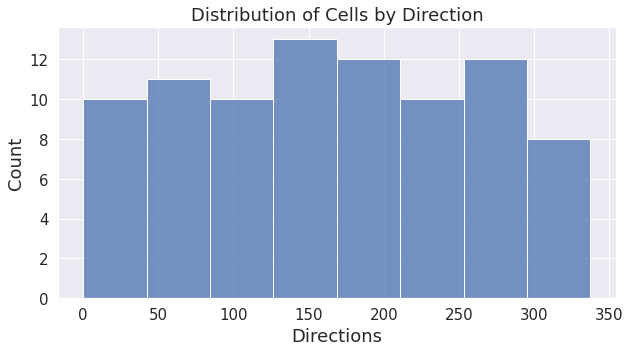

In [36]:
plot_df_upper_right_quad_DSI = upper_right_quad_DSI.loc[:,'pref_dir'].values
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=plot_df_upper_right_quad_DSI)
ax.set_title('Distribution of Cells by Direction',fontsize=18)
ax.set_xlabel('Directions',fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.set_ylabel('Count', fontsize=18)

In [37]:
high_osi_m = np.array(coreg_all_good_scans_dsi_osi['OSI']>=0.65)
low_osi_m = np.array(coreg_all_good_scans_dsi_osi['OSI']<=0.2)
mean_act_m = np.array(coreg_all_good_scans_dsi_osi['Act_Pref_Or']>=20)

In [38]:
np.sum(high_osi_m & mean_act_m)

111

In [39]:
upper_right_quad_OSI = coreg_all_good_scans_dsi_osi[high_osi_m & mean_act_m]

Text(0, 0.5, 'Count')

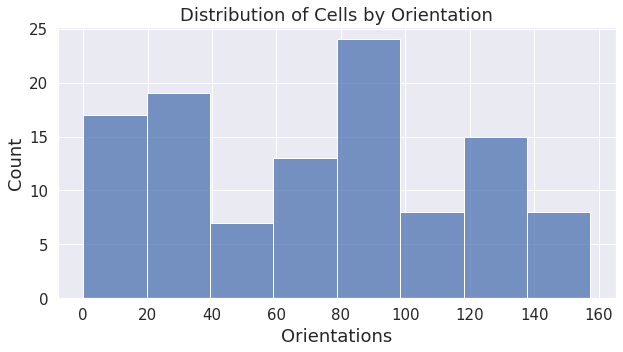

In [40]:
plot_df_upper_right_quad_OSI = upper_right_quad_OSI.loc[:,'pref_or'].values
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=plot_df_upper_right_quad_OSI)
ax.set_title('Distribution of Cells by Orientation',fontsize=18)
ax.set_xlabel('Orientations',fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.set_ylabel('Count', fontsize=18)